In [1]:
from qdrant_client import QdrantClient, models

In [2]:
qd_client = QdrantClient("http://localhost:6333")

In [5]:
from fastembed import TextEmbedding

model_handle = "jinaai/jina-embeddings-v2-small-en"
EMBEDDING_DIMENSIONALITY = 512

In [6]:
#to delete a collection and make it again
# client.delete_collection(collection_name=collection_name)

# # Define the collection name
collection_name = "resume-rag"

# # Create the collection with specified vector parameters
# client.create_collection(
#     collection_name=collection_name,
#     vectors_config=models.VectorParams(
#         size=EMBEDDING_DIMENSIONALITY,  # Dimensionality of the vectors
#         distance=models.Distance.COSINE  # Distance metric for similarity search
#     )
# )

# points = []
# for i, doc in enumerate(document_raw):
#     point = models.PointStruct(
#         id=doc["id"],  # or use id=i
#         vector=models.Document(text=doc["text"], model=model_handle),
#         payload={
#             "text": doc["text"],
#             "section": doc["metadata"]["section"]
#         }
#     )
#     points.append(point)

In [5]:
# client.upsert(
#     collection_name="resume-rag",
#     points=points
# )

In [7]:
from dotenv import load_dotenv
import os
from openai import OpenAI

# Load from .env
load_dotenv()

True

In [8]:
# openai api
API_KEY=os.environ.get("OPENAI_API_KEY")
openai_client = OpenAI(
    api_key=API_KEY
)

In [9]:
# groq api
API_KEY=os.environ.get("GROQ_API_KEY")
groq_client = OpenAI(
    api_key=API_KEY,
    base_url="https://api.groq.com/openai/v1"
)

In [6]:
from ollama import Client

ollama_client = Client()

In [8]:
def vector_search(question, section="Work Experience"):
    #print('vector_search is used')

    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="section",
                    match=models.MatchValue(value=section)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )
    
    # Extract just the payloads (text + section)
    results = []
    for point in query_points.points:
        results.append(point.payload)
    
    return results


In [289]:
def vector_search(question, sections=["Work Experience"]):
    # Support both string and list inputs
    if isinstance(sections, str):
        sections = [sections]

    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="section",
                    match=models.MatchAny(any=sections)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )

    # Extract just the payloads (text + section)
    results = [point.payload for point in query_points.points]
    
    return results


In [11]:
def build_prompt(query, search_results):
    prompt_template = """
You are a resume assistant. Use the CONTEXT below to answer the QUESTION based only on the candidate's resume.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}

If the answer is not found in the context, reply with "Not available in the resume.
""".strip()

    context = ""
    # for doc in search_results:
    #     context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    for doc in search_results:
        text = doc.get("text", "")
        section = doc.get("section", "Unknown Section")
        context += f"[{section}] {text}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [351]:
# openai api
# def llm(prompt):
#     response = openai_client.chat.completions.create(
#         model='gpt-4o-mini',
#         messages=[{"role": "user", "content": prompt}]
#     )
    
#     return response.choices[0].message.content

# groq api
def llm(prompt):
    response = groq_client.chat.completions.create(
        model= "llama-3.3-70b-versatile", #"llama-3.3-70b-versatile",   #"mistral-saba-24b",  # or "llama3-8b-8192", "gemma-7b-it"
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

# from ollama import Client

# ollama_client = Client()

# # ollama
# def llm(prompt):
#     response = ollama_client.chat(
#         model='mistral',
#         messages=[{"role": "user", "content": prompt}]
#     )
#     return response['message']['content']

In [148]:
def rag(query):
    #search_results = vector_search(query, 'Work Experience')
    search_results = vector_search(query, sections=["Work Experience", "Projects", "Skills","Education"])
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [13]:
print(rag('Summarise the key strengths'))

The key strengths of the candidate are:

1. Machine Learning (ML) training and development
2. Project efficiency improvement
3. AI solution development for secure data processing
4. ML pipeline optimization
5. Revenue growth through machine learning techniques, particularly in predictive modeling and customer value estimation.

These strengths are evident from the candidate's experience in training team members, developing ML solutions, improving pipeline efficiency, and generating significant revenue through machine learning applications.


In [21]:
print(rag('Summarise the key strengths'))

The key strengths of the candidate include:

1. Training and team management: Proven ability to train 10+ members across multiple clients.
2. AI and Machine Learning solution development: Skilled in developing secure solutions for processing sensitive data.
3. ML pipeline optimization: Able to improve efficiency by reducing grid search time and streamlining model logging.
4. Machine learning techniques: Experienced in using techniques like Decision Trees, gradient-boosted decision trees, and performance metrics.
5. Revenue generation: Successful in generating significant revenue through optimized call center interactions and predictive revenue forecasting.


In [20]:
print(rag('How many years of work experience are there?'))

To determine the total years of work experience, we need to calculate the duration of employment at each position and then add them together.

1. At Securiti, Karachi, Pakistan, the candidate started working in 11/2024 and is still working, so the duration is from 11/2024 to the current date. Since the current date is not specified, we can't calculate the exact duration, but it is less than a year.

2. At Afiniti Software Solutions Ltd., Remote:
   - The candidate worked as a Junior Data Scientist from 02/2020 to 05/2021, which is approximately 1 year and 3 months.
   - Then, as a Data Scientist from 05/2021 to 05/2022, which is approximately 1 year.
   - Finally, as a Data Scientist II from 05/2022 to 10/2024, which is approximately 2 years and 5 months.

Adding these durations together: 
- Less than a year at Securiti
- Approximately 1 year and 3 months + 1 year + 2 years and 5 months at Afiniti = 4 years and 8 months

So, the total work experience is approximately more than 4 years 

In [98]:
print(rag('Summarise the key strengths?'))

The key strengths of the candidate include:

1. **Training and Leadership**: Experience in training over 10 team members on the ML pipeline, R programming, and client business, enhancing project efficiency.
  
2. **Process Improvement**: Proven ability to improve the efficiency of the ML pipeline by implementing strategies that significantly reduce processing time and standardize model logging.

3. **End-to-End ML Development**: Skilled in managing the full ML lifecycle, from data collection and preparation to model training, evaluation, and production readiness, particularly for sensitive data.

4. **Advanced ML Techniques**: Expertise in fine-tuning advanced models like LLaMA 3 for classification tasks, achieving high accuracy and adaptability in data processing.

5. **Impactful Analytics**: Experience in optimizing business processes, such as call center interactions, through machine learning, resulting in significant revenue generation.


In [97]:
print(rag('what work has the candidate done with deep learning?'))

The candidate has built a CNN-based model to detect the header row location within semi-structured tabular files, achieving 96% accuracy and <250ms inference latency. Additionally, they have developed AI and Machine Learning solutions managing the full ML lifecycle, which includes model training and evaluation, and they have utilized gradient-boosted decision trees for predictive revenue forecasting and customer churn models.


In [24]:
print(rag('Summarise the key strengths?'))

vector_search is used
The candidate's key strengths include:

1. Strong training and leadership skills, evidenced by training over 10 members on ML pipelines and R programming, leading to increased project efficiency.
2. Proven ability to enhance operational efficiency, demonstrated by reducing grid search time by 50% and streamlining model logging processes.
3. Expertise in developing secure AI and Machine Learning solutions, managing the full ML lifecycle effectively.
4. Proficient in fine-tuning machine learning models, with a notable achievement of ~92% accuracy in classifying personal data types.
5. Successful application of machine learning techniques to optimize business processes, resulting in significant revenue generation for the company.


In [25]:
print(rag('what roles is the candidate suited for'))

vector_search is used
The candidate is suited for roles such as:

1. Machine Learning Engineer - due to their experience with gradient-boosted decision trees and fine-tuning models like LLaMA 3.
2. Data Scientist - given their skills in predictive modeling, customer churn analysis, and working with structured data types.
3. AI/ML Trainer - as they have trained team members on ML pipelines and R programming, enhancing project efficiency.
4. Research Scientist - due to their experience with achieving high accuracy in classification tasks and model deployment. 
5. Technical Consultant - for their ability to integrate models into existing production systems and collaborate with engineering teams.


# Evaluation

In [291]:
import json

with open("../data/resume.json", "r", encoding="utf-8") as f:
    document_raw = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/resume.json'

### Ground Truth Data

In [320]:
prompt_template = """
You are an interviewer preparing for a behavioral or technical interview.
Your goal is to write 5 clear and complete questions that would directly elicit the following resume entry as an answer.
Only ask questions that can be directly answered using the provided entry. 
If the entry only includes company, job title, location, and dates, avoid asking technical or project-based questions.
Avoid copying exact phrases from the resume — the questions should sound natural, but their answers should be well covered by the entry.

section: {section}
entry: {text}

Provide the output in a JSON array only without using code blocks:
["question1", "question2", ..., "question5"]
""".strip()

# Formulate 5 questions a recruiter might ask during an interview based on the following resume entry.
# Each question should probe deeper into the candidate's experience, technical choices, outcomes, or reasoning.

# your current prompt is quite good, but it’s subtly prompting the model to review 
# the resume and formulate questions based on it, 
# which might lead to generic or curiosity-based questions 
# (e.g. "Can you elaborate on your experience at XYZ?") rather than 
# questions that would elicit that exact resume entry as the answer.

In [321]:
doc = document_raw[0]
prompt = prompt_template.format(
        section=doc["metadata"]["section"],
        text=doc["text"]
    )
print(prompt)  # 

You are an interviewer preparing for a behavioral or technical interview.
Your goal is to write 5 clear and complete questions that would directly elicit the following resume entry as an answer.
Only ask questions that can be directly answered using the provided entry. 
If the entry only includes company, job title, location, and dates, avoid asking technical or project-based questions.
Avoid copying exact phrases from the resume — the questions should sound natural, but their answers should be well covered by the entry.

section: Work Experience
entry: Work Experience
Securiti, Karachi, Pakistan	11/2024 – Current
Data Scientist

Provide the output in a JSON array only without using code blocks:
["question1", "question2", ..., "question5"]


In [35]:
def generate_questions(doc):
    prompt = prompt_template.format(
        section=doc["metadata"]["section"],
        text=doc["text"]
    )

    response = openai_client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )

    json_response = response.choices[0].message.content
    return json_response

In [36]:
from tqdm.auto import tqdm

In [325]:
results = {}

In [296]:
len(results)

19

In [295]:
len(document_raw)

19

In [110]:
document_raw

list

In [126]:
print(document_raw[7]) # 0, 6, 

print(generate_questions(document_raw[7]))

{'id': 'f6fce825-d0ec-474e-b869-948eaed8b877', 'text': 'Optimized call center interactions using machine learning techniques like Decision Trees and performance metrics to estimate customer lifetime value and agent impact, generating over $1 million in revenue per month for SKY UK.', 'metadata': {'section': 'Work Experience'}}
[
    "Can you describe the techniques you utilized to enhance call center interactions?",
    "What specific performance metrics did you focus on to assess customer lifetime value?",
    "How did your work contribute to revenue generation at SKY UK?",
    "Can you explain the role of machine learning in your approach to optimizing interactions?",
    "What impact did the optimization have on the call center agents and their performance?"
]


In [326]:
for doc in tqdm(document_raw): 
    doc_id = doc['id']
    if doc_id in results:
        continue

    questions = generate_questions(doc)
    #print(questions)
    results[doc_id] = questions

  0%|          | 0/19 [00:00<?, ?it/s]

In [328]:
questions

'["What courses did you take that are related to machine learning?", "Can you list some of the subjects you studied that involved data structures?", "Which programming concepts did you learn in your education?", "What foundational courses did you take in statistics?", "How did your studies in object-oriented programming influence your understanding of software development?"]'

In [327]:
len(results)

19

In [161]:
19*5

95

In [135]:
print(results['1eceaa59-8ffd-44fc-bc14-e5c5f49e1a1a'])

['Can you describe your experience with fine-tuning models like LLaMA 3?', 'What techniques did you use to improve the accuracy of classifying personal data types?', 'How did you ensure that the model could handle newly added personal data types during inference?', 'Could you explain the significance of achieving approximately 92% accuracy in your classification task?', 'What were the structured tables used for in your project, and how did they relate to your work?']


In [130]:
print(document_raw[17])

{'id': 'cae27263-b9ea-443e-91cf-6eacc852dbd2', 'text': 'Education\nNational University of Sciences and Technology, Islamabad, Pakistan\t2015 – 2019\nB.E. Electrical Engineering', 'metadata': {'section': 'Education'}}


In [132]:
# the results dictionary contains JSON strings instead of lists, we parse the string into a real list using json.loads
# for doc_id in results:
#     if isinstance(results[doc_id], str):
#         results[doc_id] = json.loads(results[doc_id])

In [137]:
import json

# Save
with open("questions_by_doc_id.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)


# # Load later
# with open("questions_by_doc_id.json", "r", encoding="utf-8") as f:
#     results = json.load(f)

In [76]:
19*5

95

In [335]:
doc_id_to_section = {doc['id']:  doc["metadata"]["section"] for doc in document_raw}

# Flatten the results into a list of rows
rows = []
for doc_id, question_list in results.items():
    section = doc_id_to_section.get(doc_id, "Unknown")

     # Fix improperly stored stringified lists
    if isinstance(question_list, str):
        try:
            question_list = json.loads(question_list)
        except json.JSONDecodeError:
            print(f"Failed to decode questions for doc_id {doc_id}")
            continue
            
    for question in question_list:
        #print(question)
        rows.append({
            "question": question,
            "section": section,
            "doc_id": doc_id
        })

# Convert to DataFrame
df = pd.DataFrame(rows)

In [298]:
19*5

95

In [336]:
len(rows)

95

In [340]:
!pwd

/c/projects/ask_my_resume


In [341]:
df.to_csv('data/ground_truth_data.csv', index=False)

In [343]:
!head data/ground_truth_data.csv

question,section,doc_id
What is your current job title and where do you work?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
Can you tell me about the location of your current workplace?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
When did you start your current position?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
Are you currently working as a Data Scientist?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
What company are you employed with at the moment?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
Can you describe the type of solutions you developed related to AI and Machine Learning?,Work Experience,81b009b4-ca83-4f13-8549-684bceb6d767
What was your role in managing the lifecycle of machine learning projects?,Work Experience,81b009b4-ca83-4f13-8549-684bceb6d767
How did you ensure the security of sensitive data during your work?,Work Experience,81b009b4-ca83-4f13-8549-684bceb6d767
What tasks did you perform in the data collection and preparation

In [344]:
import pandas as pd
df_ground_truth = pd.read_csv('data/ground_truth_data.csv')
df_ground_truth.head()

,question,section,doc_id
0,What is your current job title and where do yo...,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
1,Can you tell me about the location of your cur...,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
2,When did you start your current position?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
3,Are you currently working as a Data Scientist?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
4,What company are you employed with at the moment?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9


In [347]:
#ground_truth = df_ground_truth[df_ground_truth.section.str.contains("Work Experience|Projects")].to_dict(orient='records')
ground_truth = df_ground_truth.to_dict(orient='records')
len(ground_truth)

95

In [348]:
#creating an index on document_raw to quickyl retrive the doc id answer from document_raw:
# builds a dictionary (lookup index) where  key is id value from each document, and value is the full document entry
doc_idx = {d["id"]: d for d in document_raw}

# # Now you can instantly access:
# doc_text = doc_idx['3e1e2fd4-45c5-47dd-b4e6-f68835f53f6d']["text"]
# doc_section = doc_idx['3e1e2fd4-45c5-47dd-b4e6-f68835f53f6d']["metadata"]["section"]
# doc_text

'Integrated PyTorch models into a Java-based production pipeline for performance testing, collaborating closely with engineering teams to ensure seamless deployment.'

In [349]:
answers = {}

In [179]:
ground_truth[0]['question']

'Can you tell me about your current role and responsibilities at Securiti?'

In [180]:
rag(ground_truth[0]['question'])

"At Securiti, the candidate's current role is Data Scientist. Their specific responsibilities in this role are not available in the resume."

In [352]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    #print(rec['question'])
    answer_llm = rag(rec['question'])
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'doc_id': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

  0%|          | 0/95 [00:00<?, ?it/s]

In [ ]:
#pd.DataFrame(answers.values()).sample(5).to_dict(orient='records')

In [353]:
len(answers)

95

In [354]:
df_results_llama = pd.DataFrame(answers.values())#.sample(5).to_dict(orient='records')
#os.makedirs('data', exist_ok=True)
# df_results_llama.to_csv('data/results_llama-3.3-70b-versatile.csv', index=False)
# df_results_llama.to_csv('data/llama-3.1-8b-instant.csv', index=False)

In [52]:
df_results_llama = pd.read_csv('data/results_llama-3.3-70b-versatile.csv')

In [355]:
results_llama = df_results_llama.to_dict(orient='records')

In [54]:
import sys
print(sys.executable)

C:\projects\ask_my_resume\.venv\Scripts\python.exe


In [194]:
#df_results_llama[['answer_orig','question','answer_llm']].to_dict(orient='records')

In [24]:
from sentence_transformers import SentenceTransformer
# Trained on real QA pairs from diverse domains.
model_name = 'multi-qa-MiniLM-L6-cos-v1'  #'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\projects\ask_my_resume\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nida Khan\.cache\huggingface\hub\models--sentence-transformers--multi-qa-MiniLM-L6-cos-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
from sentence_transformers import SentenceTransformer
# Trained on real QA pairs from diverse domains.
model_name_2 = 'all-MiniLM-L6-v2'
model_2 = SentenceTransformer(model_name_2)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\projects\ask_my_resume\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nida Khan\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [356]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    # v_llm = model.encode(answer_llm)
    # v_orig = model.encode(answer_orig)
    v_llm = model_2.encode(answer_llm)
    v_orig = model_2.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [357]:
similarity = []

for record in tqdm(results_llama):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/95 [00:00<?, ?it/s]

In [358]:
df_results_llama['cosine'] = similarity
df_results_llama['cosine'].describe()
df_results_llama.groupby('section')['cosine'].describe()


,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.510713,0.182568,0.090166,0.445921,0.543154,0.653294,0.685782
Projects,10.0,0.740273,0.143630,0.535940,0.633322,0.746957,0.850453,0.945555
Skills,5.0,0.491292,0.149535,0.284191,0.418129,0.485872,0.620672,0.647595
Work Experience,70.0,0.633545,0.267725,-0.061153,0.583262,0.727893,0.805798,0.926139


In [359]:
#df_results_llama[['answer_orig','question','answer_llm','cosine']].to_dict(orient='records')

In [31]:
!pip install seaborn

  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.

In [362]:
df_results_llama.to_csv('data/llama-3.3-70b-versatile_results.csv', index=False)

C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_14644\2336126269.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_llama['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

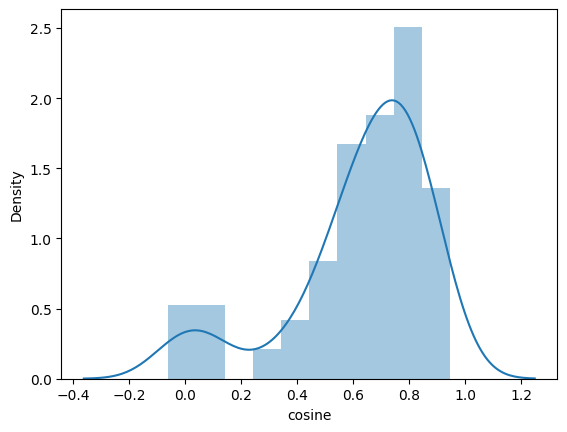

In [360]:
import seaborn as sns

sns.distplot(df_results_llama['cosine'])

### LLM as-a-Judge

In [363]:
prompt1_template = """
You are an expert evaluator for RAG-generated answers.

Given:
- A question
- A generated answer
- The original resume information

Evaluate whether the answer is:
1. **Correct** – factually answers the question well
2. **Grounded** – based only on the resume info provided

Then assign a score using this rubric:

Score 2 = Answer is correct AND grounded  
Score 1 = Answer is either correct OR grounded (but not both)  
Score 0 = Answer is neither correct nor grounded

Also provide a short explanation.

Format your output as JSON without code blocks:
{{
  "score": 0 | 1 | 2,
  "explanation": "short justification"
}}

---

QUESTION:
{question}

ANSWER:
{answer_llm}

REFERENCE (Resume Entry):
{answer_orig}
""".strip()

In [246]:
df_results_llama.loc[0, 'question']

'Can you tell me about your current role and responsibilities at Securiti?'

In [274]:
pp = prompt1_template.format(
        question=df_results_llama.loc[0, "question"],
        answer_llm=df_results_llama.loc[0, "answer_llm"],
        answer_orig=df_results_llama.loc[0, "answer_orig"]
    )

In [271]:
print(response.choices[0].message.content)

{
  'score': 1,
  'explanation': 'The answer correctly identifies the role as Data Scientist at Securiti but includes an incorrect start date of November 2024, which is not grounded in the present context since that date is in the future.'  
}


In [275]:
response = openai_client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[{"role": "user", "content": pp}]
            )
content = response.choices[0].message.content
cc = json.loads(content)

In [276]:
cc

{'score': 1,
 'explanation': 'The answer is correct in stating the role and starting date but is not grounded since the date is in the future (November 2024) and thus not possible at the time of evaluation.'}

In [364]:
import json

def evaluate_row(row):
    prompt = prompt1_template.format(
        question=row["question"],
        answer_llm=row["answer_llm"],
        answer_orig=row["answer_orig"]
    )
    
    # Call to Groq API or your LLM
    try:
        response = openai_client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[{"role": "user", "content": prompt}]
            )
        content = response.choices[0].message.content
        result = json.loads(content)

        return pd.Series({
            "score_llm_eval": result.get("score"),
            "judge_explanation": result.get("explanation")
        })

    except Exception as e:
        return pd.Series({
            "score_llm_eval": None,
            "judge_explanation": f"Error: {str(e)}"
        })


In [365]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_results_llama[["score_llm_eval", "judge_explanation"]] = df_results_llama.progress_apply(evaluate_row, axis=1)

  0%|          | 0/95 [00:00<?, ?it/s]

In [366]:
df_results_llama['score_llm_eval'].value_counts()

score_llm_eval
2    72
1    17
0     6
Name: count, dtype: int64

In [367]:
df_results_llama[df_results_llama.score_llm_eval==0][['answer_orig','question','answer_llm','cosine','judge_explanation']].to_dict(orient='records')

[{'answer_orig': 'Integrated PyTorch models into a Java-based production pipeline for performance testing, collaborating closely with engineering teams to ensure seamless deployment.',
  'question': 'What challenges did you face when integrating different technologies like PyTorch and Java?',
  'answer_llm': 'Not available in the resume.',
  'cosine': -0.045038048177957535,
  'judge_explanation': 'The answer is incorrect as it does not address the question about challenges faced during integration. It is also not grounded, as it does not use or reference the information provided in the resume.'},
 {'answer_orig': 'Fine-tuned LLaMA 3 using PEFT (LoRA) to classify personal data (PD) types of columns in structured tables, achieving ~92% accuracy across 15+ PD types, and enabling classification of newly added PD types during inference.',
  'question': 'What was the significance of reaching approximately 92% accuracy in your project?',
  'answer_llm': 'Not available in the resume.',
  'cosi